# Проект: Прогнозирование заказов такси

___
**Описание проекта**  

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах.
___
**Цель**  

Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания. Значение метрики RMSE на тестовой выборке должно быть не больше 48.
___
**Инструкция по выполнению проекта.**  

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.
___
**Описание данных:**  

Данные находятся в файле `/datasets/taxi.csv`

*Признаки*

- Количество заказов находится в столбце `num_orders` (от англ. number of orders, «число заказов»).

<h1>Содержание<span class="tocSkip"></span></h1><br>
<div class="toc">
    <ul class="toc-item">
        <li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1">
            <span class="toc-item-num">1.&nbsp;&nbsp;</span>Подготовка данных</a></span>
        </li>
        <li><span><a href="#Анализ" data-toc-modified-id="Анализ-2">
            <span class="toc-item-num">2.&nbsp;&nbsp;</span>Анализ</a></span>
        </li>
        <li><span><a href="#Обучение" data-toc-modified-id="Обучение-3">
            <span class="toc-item-num">3.&nbsp;&nbsp;</span>Обучение</a></span>
        </li>
        <li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4">
            <span class="toc-item-num">4.&nbsp;&nbsp;</span>Тестирование</a></span>
        </li>
        <li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5">
            <span class="toc-item-num">5.&nbsp;&nbsp;</span>Общий вывод</a></span>
        </li>
        <li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6">
            <span class="toc-item-num">6.&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span>
        </li>
    </ul>
</div>

## Подготовка данных

### Импортируем необходимые библиотеки. Считаем данные из csv-файла в датафрейм и сохраним в переменную `df`. Путь к файлу:

`/datasets/taxi.csv`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from scipy import stats as st

In [2]:
# импортируем функцию seasonal_decompose из statsmodels 
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams

#Инициализация модели LinearRegression
from sklearn.linear_model import LinearRegression

#Инициализация модели DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

#Инициализация модели CatBoostRegressor
from catboost import CatBoostRegressor

#Инициализация модели LightGBM
!pip install lightgbm
import lightgbm as lgb

#Кодирование категориальных признаков в виде одноточечного числового массива
from sklearn.preprocessing import OneHotEncoder

#Кодирование категориальных признаков в виде целочисленного массива.
from sklearn.preprocessing import OrdinalEncoder

#Разделение выборки в заданных пропорциях
from sklearn.model_selection import train_test_split

#Преобразователь масштаба методом стандартизации
from sklearn.preprocessing import StandardScaler

#Поиск лучших параметров модели
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

#Проверка модели на адекватность
from sklearn.dummy import DummyRegressor

#Метрики регрессии
from sklearn.metrics import r2_score, mean_squared_error

#Последовательное перемешивание массивов или разреженных матриц
from sklearn.utils import shuffle

#Сохранение и загрузка обученной модели
import joblib

In [3]:
try:
    df = pd.read_csv('./taxi.csv')
except:
    print('File_not_found')

### Изучим общую информацию о полученном датафрейме

**Добавим настройки для удобства отображения данных**

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(suppress=True)

#Если необходимо вернуть дефолтные настройки, раскомментируй строку ниже
#pd.reset_option('all')

**Выведем первые 10 строчек датафрейма `df` на экран.**

In [5]:
df.head(10)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


**Посмотрим на размер данных (количество строк, колонок).**

In [6]:
print(f'\nКоличество строк: {df.shape[0]}\nКоличество колонок: {df.shape[1]}\n')


Количество строк: 26496
Количество колонок: 2



**Просмотрим статистическую сводку каждой колонки, чтобы узнать распределение данных в каждой колонки. Используем метод `describe()`.**

In [7]:
df.describe(include = "all")

,datetime,num_orders
count,26496,"26,496.00"
unique,26496,NaN
top,2018-04-27 04:00:00,NaN
freq,1,NaN
mean,NaN,14.07
std,NaN,9.21
min,NaN,0.00
25%,NaN,8.00
50%,NaN,13.00
75%,NaN,19.00


*Признаки*

- `datetime` — Дата
- `num_orders` — Количество заказов

**Выведем основную информацию о датафрейме с помощью метода `info()`.**

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


**Выведем количество пропущенных значений для каждой колонки.**

In [9]:
pd.DataFrame(df.isna().sum()).style.background_gradient('coolwarm')

,0
datetime,0
num_orders,0


**Выведем пропущенные значения в процентном соотношении.**

In [10]:
pd.DataFrame(df.isna().mean()).style.format("{:.2%}").background_gradient('coolwarm')

,0
datetime,0.00%
num_orders,0.00%


**Проверим дубликаты.**

In [11]:
df.duplicated().sum()

0

**Выявлены следующие проблемы:**

>1. Измените тип данных в признаке `datetime` с `object` на `datetime64`;
>2. Установить индекс таблицы равным столбцу `datetime`;
>3. Проверить, находятся ли в хронологическом ли порядке даты и время;
>4. Выполнить ресемплирование даты по одному часу.

### Работа с типом данных

**Изменим тип значений `object` на `datetime64` в признаках `datetime`.**

In [12]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')

### Изменение индекса датафрейма

**Установим индекс датафрейма равным столбцу `datetime`.**

In [13]:
df.set_index('datetime', inplace=True)

### Проверка хронологического порядка

**Посмотрим атрибут индекса датафрейма `is_monotonic`. Если порядок соблюдён, атрибут вернёт `True`, если нет — `False`.**

In [14]:
print(df.index.is_monotonic)

True


### Ресемплирование

**Выполнить ресемплирование даты по одному часу.**

In [15]:
df = df.resample('1H').sum()

## Анализ

### Работа с графиками

**Построим простой график изменения данных во времени.**

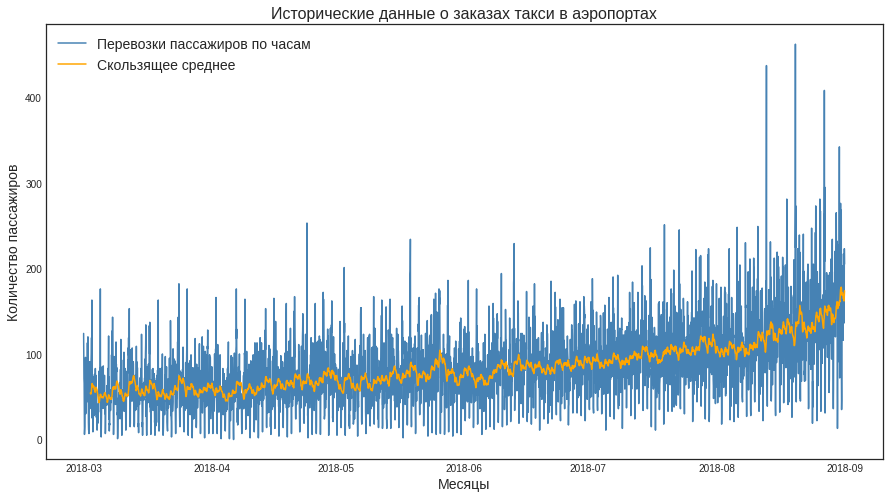

In [16]:
# зададим размер графика
plt.figure(figsize = (15,8))
plt.style.use('seaborn-white')

# поочередно зададим кривые (перевозки и скользящее среднее) с подписями и цветом
plt.plot(df, label = 'Перевозки пассажиров по часам', color = 'steelblue')
plt.plot(df.rolling(window = 40).mean(), label = 'Скользящее среднее', color = 'orange')

# добавим легенду, ее положение на графике и размер шрифта
plt.legend(title = '', loc = 'upper left', fontsize = 14)

# добавим подписи к осям и заголовки
plt.xlabel('Месяцы', fontsize = 14)
plt.ylabel('Количество пассажиров', fontsize = 14)
plt.title('Исторические данные о заказах такси в аэропортах', fontsize = 16)

# выведем обе кривые на одном графике
plt.show()

**Разложение временного ряда на компоненты.**

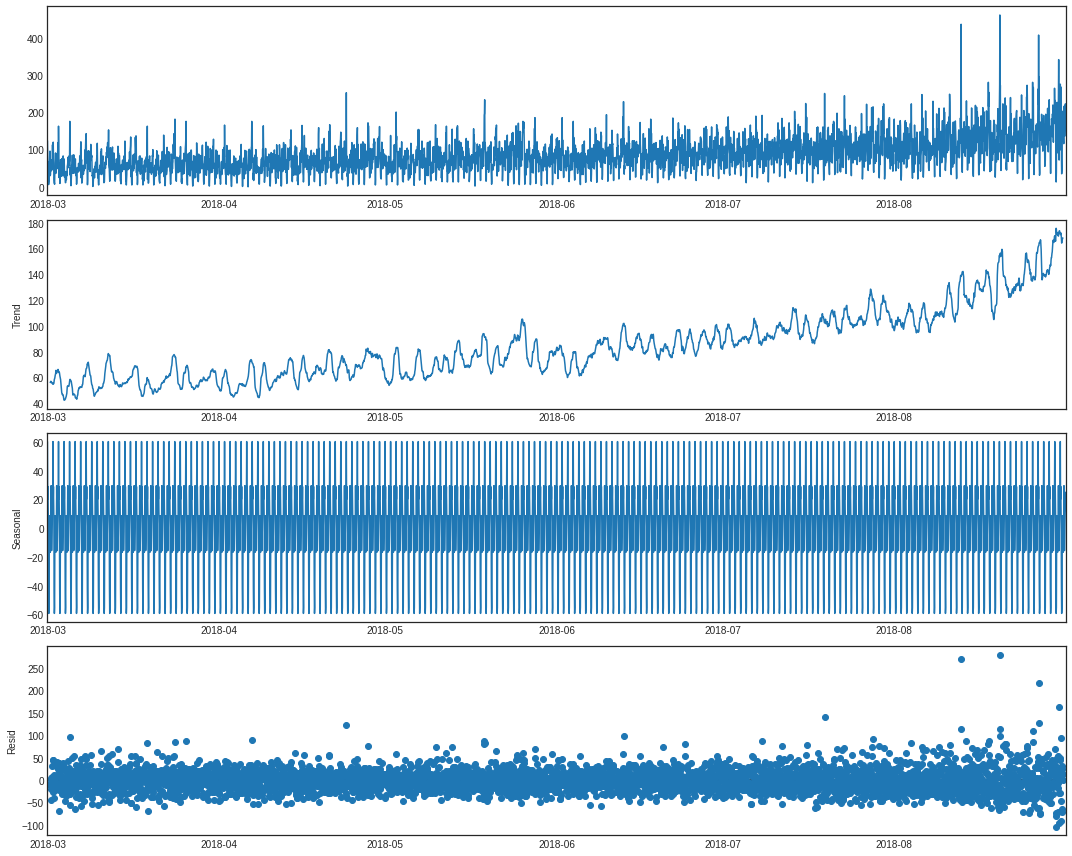

In [17]:
rcParams['figure.figsize'] = (15, 12)

decompose = seasonal_decompose(df)
decompose.plot()

plt.show()

**Тренд за последний месяц.**

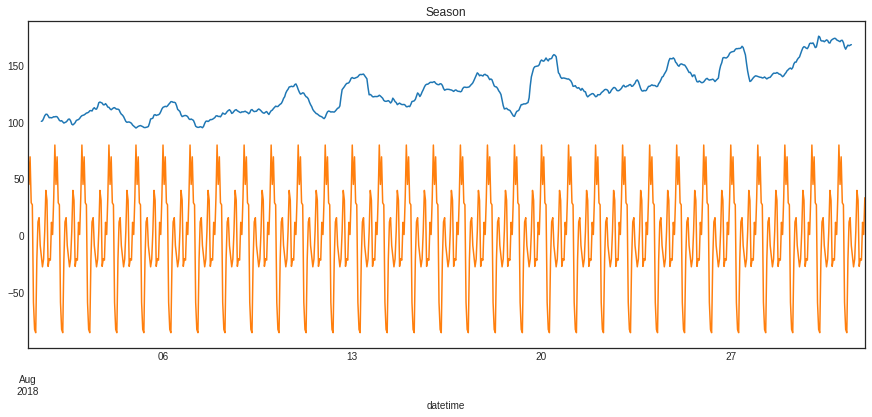

In [18]:
rcParams['figure.figsize'] = (15, 6)

decompose = seasonal_decompose(df['2018-08':'2018-08'])
decompose.trend.plot()
decompose.seasonal.plot()
plt.title('Season')

plt.show()

**Выводы изучения распределения числовых признаков:**

>1. Наблюдается тренд равномерного роста заказов с периодическими небольшими падениями
>2. Распределение сезонной части выглядит статическим в интервале суток. Ночью такси почти не заказывают, пик ближе к вечеру.
>3. Случайная часть также имеет постоянной среднее значение, но периодически возникают большие всплески (объясняются повышенным спросом на такси по выходным и праздникам)
>4. Трэнд показывает линейный рост количества заказов со временем.

## Обучение

### Подготовка признаков

**Создадим признаки для обучения модели.**
**Напишем функцию для создания признаков.**

In [19]:
def get_features(df_learning):
    df_learning['month'] = df_learning.index.month
    df_learning['day'] = df_learning.index.day
    df_learning['dayofweek'] = df_learning.index.dayofweek
    df_learning['hour'] = df_learning.index.hour
    
    for lag in range(1, 6):
        df_learning['lag_{}'.format(lag)] = df_learning['num_orders'].shift(lag)
    
    df_learning['rolling_mean'] = df_learning['num_orders'].shift().rolling(1).mean()
    df_learning.dropna(inplace=True)
    
    return df_learning

In [20]:
df_learning = df.copy()
df_learning = get_features(df_learning)

In [21]:
df_learning.shape

(4411, 11)

**Выделение признаков.**

In [22]:
features = df_learning.drop(['num_orders'], axis=1)
target = df_learning['num_orders']

**Разделим исходные данные на `обучающую` и `тестовую`.**

In [23]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, shuffle=False, test_size=0.1, random_state=42)

**Выберем следующие регрессоры для обучения модели:**

- `DecisionTreeRegressor`
- `CatBoostRegressor`
- `LGBMRegressor`

**Обучим различные модели и добавим модели и рассчитанный RMSE в массив.**

In [24]:
train_models = []

### DecisionTreeRegressor

In [25]:
model = DecisionTreeRegressor(random_state=42)

In [26]:
parameters = {'max_depth':range(1,11,2)}

tscv = TimeSeriesSplit(n_splits=2)

In [27]:
gsearch = GridSearchCV(estimator=model, cv=tscv, scoring='neg_root_mean_squared_error', param_grid=parameters)

In [28]:
%%time

gsearch.fit(features_train, target_train)
gsearch.best_params_

CPU times: user 153 ms, sys: 3.81 ms, total: 157 ms
Wall time: 164 ms


{'max_depth': 9}

In [29]:
rmse = gsearch.best_score_
rmse

-33.167060920806236

In [30]:
train_models.append([model, rmse])

### CatBoostRegressor

In [31]:
model = CatBoostRegressor()

In [32]:
parameters = {'max_depth': [2, 4, 6],
              'learning_rate': [0.01, 0.02, 0.03],
              'l2_leaf_reg': [1, 3, 5],
              'logging_level': ['Silent']}

tscv = TimeSeriesSplit(n_splits=2)

In [33]:
gsearch = GridSearchCV(estimator=model, cv=tscv, scoring='neg_root_mean_squared_error', param_grid=parameters)

In [34]:
%%time

gsearch.fit(features_train, target_train)
gsearch.best_params_

CPU times: user 55.1 s, sys: 4.62 s, total: 59.7 s
Wall time: 1min 38s


{'l2_leaf_reg': 3,
 'learning_rate': 0.03,
 'logging_level': 'Silent',
 'max_depth': 4}

In [35]:
rmse = gsearch.best_score_
rmse

-28.248427554786872

In [36]:
train_models.append([model, rmse])

### LGBMRegressor

In [39]:
model = lgb.LGBMRegressor()

In [40]:
parameters = {'max_depth': [2, 4, 6],
              'learning_rate': [0.03, 0.1],
              'n_estimators': [50, 100, 200]}

tscv = TimeSeriesSplit(n_splits=2)

In [41]:
gsearch = GridSearchCV(estimator=model, cv=tscv, scoring='neg_root_mean_squared_error', param_grid=parameters)

In [48]:
%%time

gsearch.fit(features_train, target_train)
gsearch.best_params_

In [49]:
rmse = gsearch.best_score_
rmse

In [ ]:
train_models.append([model, rmse])

### Промежуточные результаты

In [ ]:
results = pd.DataFrame(train_models, columns=['model', 'rmse_train'])

In [ ]:
print(results)

**Лучший результат показала модель `LGBMRegressor`. Возьмём её для дальнейшего тестирования.**

## Тестирование

**Протестируем обученную модель `LGBMRegressor` на тестовых данных, а также построим графики исходного и предсказанных рядов для модели.**

In [ ]:
train_models[3][0]

In [44]:
model = train_models[1][0]

In [45]:
model.fit(features_train, target_train)

Learning rate set to 0.050906
0:	learn: 37.7743742	total: 2.65ms	remaining: 2.64s
1:	learn: 36.8695321	total: 4.82ms	remaining: 2.41s
2:	learn: 36.0198954	total: 6.89ms	remaining: 2.29s
3:	learn: 35.2578773	total: 8.72ms	remaining: 2.17s
4:	learn: 34.5713357	total: 10.8ms	remaining: 2.15s
5:	learn: 33.9829491	total: 12.7ms	remaining: 2.1s
6:	learn: 33.3311582	total: 14.6ms	remaining: 2.07s
7:	learn: 32.7042455	total: 16.5ms	remaining: 2.04s
8:	learn: 32.1821754	total: 18.5ms	remaining: 2.04s
9:	learn: 31.7210654	total: 20.5ms	remaining: 2.03s
10:	learn: 31.3847531	total: 22.3ms	remaining: 2s
11:	learn: 30.8651137	total: 24.4ms	remaining: 2.01s
12:	learn: 30.4809884	total: 26.4ms	remaining: 2s
13:	learn: 30.0946252	total: 28.5ms	remaining: 2.01s
14:	learn: 29.7039210	total: 30.5ms	remaining: 2s
15:	learn: 29.3434094	total: 32.4ms	remaining: 1.99s
16:	learn: 29.0514076	total: 34.7ms	remaining: 2.01s
17:	learn: 28.8113547	total: 36.8ms	remaining: 2.01s
18:	learn: 28.5026188	total: 38.8ms	

In [46]:
predictions = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions, squared=False)
rmse

43.65704453177096

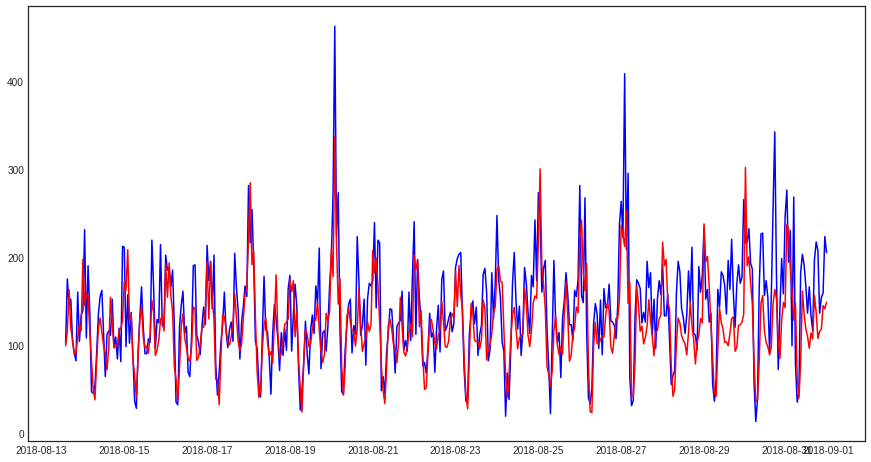

In [47]:
plt.figure(figsize = (15,8))
plt.plot(target_test.index, 
         target_test, 
         'b-', 
         target_test.index, 
         predictions,
         'r-')
plt.show()

## Общий вывод

**По результатам исследований моделей для поставленной задачи наиболее оптимальными являются модели:**  

- `CatBoostRegressor`
- `LGBMRegressor`

**`CatBoostRegressor` показывает хорошие показатели метрик и скорости обучения и предсказания. Значение `RMSE` на тестовой выборке не больше `48`.**

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48